---
## Script para la elaboración de mapas de Chile.
---

**Autor**: Rodrigo Hernández A.  
**Tutora**: Dra. Nery Sofía Huerta.  
**Fecha**: 2 de Octubre, 2023.  

---

### Descripción:
Este script crea visualizaciones de mapas temáticos para Chile, usando el paquete chilemapas.  
>Vargas M (2022). _chilemapas: Mapas de las Divisiones Politicas y Administrativas de Chile (Maps of the Political and Administrative Divisions of Chile)_. R package version 0.3.0,
  <https://CRAN.R-project.org/package=chilemapas>.

**Entorno**: R en Google Colab  
**Proyecto**: TFM - Máster en Big Data y Ciencia de Datos - Universidad Internacional de Valencia (VIU).

---

In [ ]:
install.packages("googledrive")
library(googledrive)
drive_auth(use_oob = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=2d5c9e8f3135563ae64836eb67d06305&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa01BLTUxektmUVBWck01SFMwQmNleFI5VlBxSmhCMWJITmoyZ1VfcjItQzhuWHJNT1VyWmxaU0tFMEVpeGxNQSIsInN0YXRlIjoiMmQ1YzllOGYzMTM1NTYzYWU2NDgzNmViNjdkMDYzMDUifQ==


In [ ]:
install.packages("chilemapas")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘geometries’, ‘rapidjsonr’, ‘sfheaders’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’, ‘geojsonsf’, ‘jsonify’, ‘sp’, ‘V8’, ‘sf’, ‘rmapshaper’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(chilemapas)
library(ggplot2)
library(dplyr)
library(sf)
library(ggrepel)

Loading required package: sf

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

La documentacion del paquete y ejemplos de uso se encuentran en https://pacha.dev/chilemapas/.
Visita https://buymeacoffee.com/pacha/ si deseas donar para contribuir al desarrollo de este software.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
# Archivos usando el enlace compartido
archivo_conduccion <- drive_get("https://docs.google.com/spreadsheets/d/1ZYmSsR5HvTFF4KMSzdyRDSKPS3_7oUcX/edit?usp=sharing&ouid=100028925563193391093&rtpof=true&sd=true")

# Descargando el archivo al entorno de Colab
drive_download(archivo_conduccion, path = "conduccion_110823_15_22.xlsx", overwrite = TRUE)

# Leyendo los archivos descargados
library(readxl)
conduccion <- read_excel("conduccion_110823_15_22.xlsx")

File downloaded:

• conduccion_110823_15_22.xlsx <id: 1ZYmSsR5HvTFF4KMSzdyRDSKPS3_7oUcX>

Saved locally as:

• conduccion_110823_15_22.xlsx



In [ ]:
data(mapa_comunas)
mapa_comunas <- as.data.frame(mapa_comunas)
mapa_comunas <- select(mapa_comunas, -c("codigo_provincia"))
mapa_comunas <- select(mapa_comunas, -c("codigo_region"))

mapa_unido <- merge(mapa_comunas, codigos_territoriales, by = "codigo_comuna")

# Pasa todos los registros a MAYÚSCULA, sin tildes y mantiene la virgulilla de la ñ
old_chars <- "áéíóúÁÉÍÓÚ"
new_chars <- "aeiouAEIOU"
colum <- c("nombre_comuna" )
# AplicaNdo chartr()
mapa_unido[colum] <- lapply(mapa_unido[colum], function(x) if(is.character(x)) chartr(old_chars, new_chars, toupper(x)) else x)


table_year <- table(conduccion$`NOMBRE COMUNA`, conduccion$`AÑO INGRESO`)
table_year <- as.data.frame(table_year)

result <- aggregate(Freq ~ Var1, data = table_year, sum)

result <- rename(result,"nombre_comuna" = "Var1")
mapa_unido_frec <- merge(mapa_unido, result, by = "nombre_comuna", all = TRUE)
mapa_sf <- st_as_sf(mapa_unido_frec)

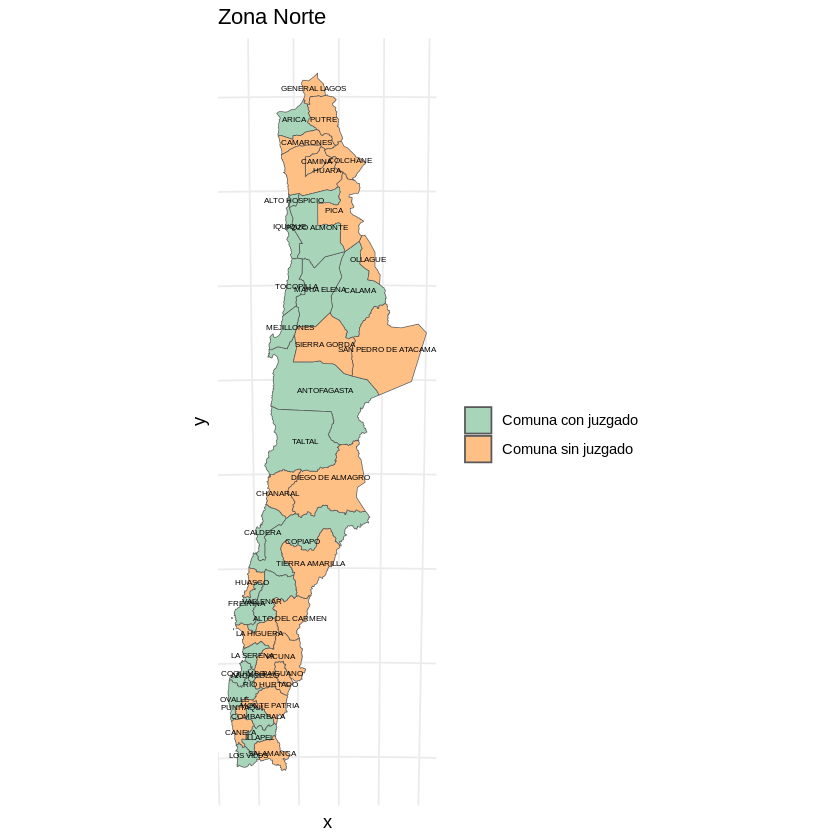

In [ ]:
# ZONA 1 (NORTE): XV, I, II, III, IV: 24 comunas
#   DE ARICA Y PARINACOTA(1), DE TARAPACA(3), DE ANTOFAGASTA(6), DE ATACAMA(6), DE COQUIMBO(8)
mapa_sf4 <- mapa_sf %>%
  filter(codigo_region %in% c("15", "01", "02", "03","04"))

# Proyectar
mapa_sf4_proj <- st_transform(mapa_sf4, crs = 5361)

mapa_sf4_proj$color_comuna <- ifelse(mapa_sf4_proj$nombre_comuna %in% c(
            "ALTO HOSPICIO","ANDACOLLO","ANTOFAGASTA","ARICA","CALAMA","CALDERA","CHAÑARAL","COMBARBALA","COPIAPO","COQUIMBO",
             "DIEGO ALMAGRO", "FREIRINA", "ILLAPEL", "IQUIQUE", "LA SERENA", "LOS VILOS", "MARIA ELENA", "MEJILLONES","OVALLE",
             "POZO ALMONTE","TALTAL","TOCOPILLA","VALLENAR","VICUÑA"
            ),
"Comuna con juzgado" , "Comuna sin juzgado" )

ggplot(data = mapa_sf4_proj) +
  geom_sf(aes(fill = color_comuna)) +
  geom_sf_text(aes(label = nombre_comuna), nudge_y = 0, nudge_x = 0, size = 1.7) +
  theme_minimal() +
  labs(title = "Zona Norte") +
  theme(
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()
  ) +
  scale_fill_manual(name="",values = c("Comuna con juzgado" = "#A8D5BA", "Comuna sin juzgado" = "#FFC085"))

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


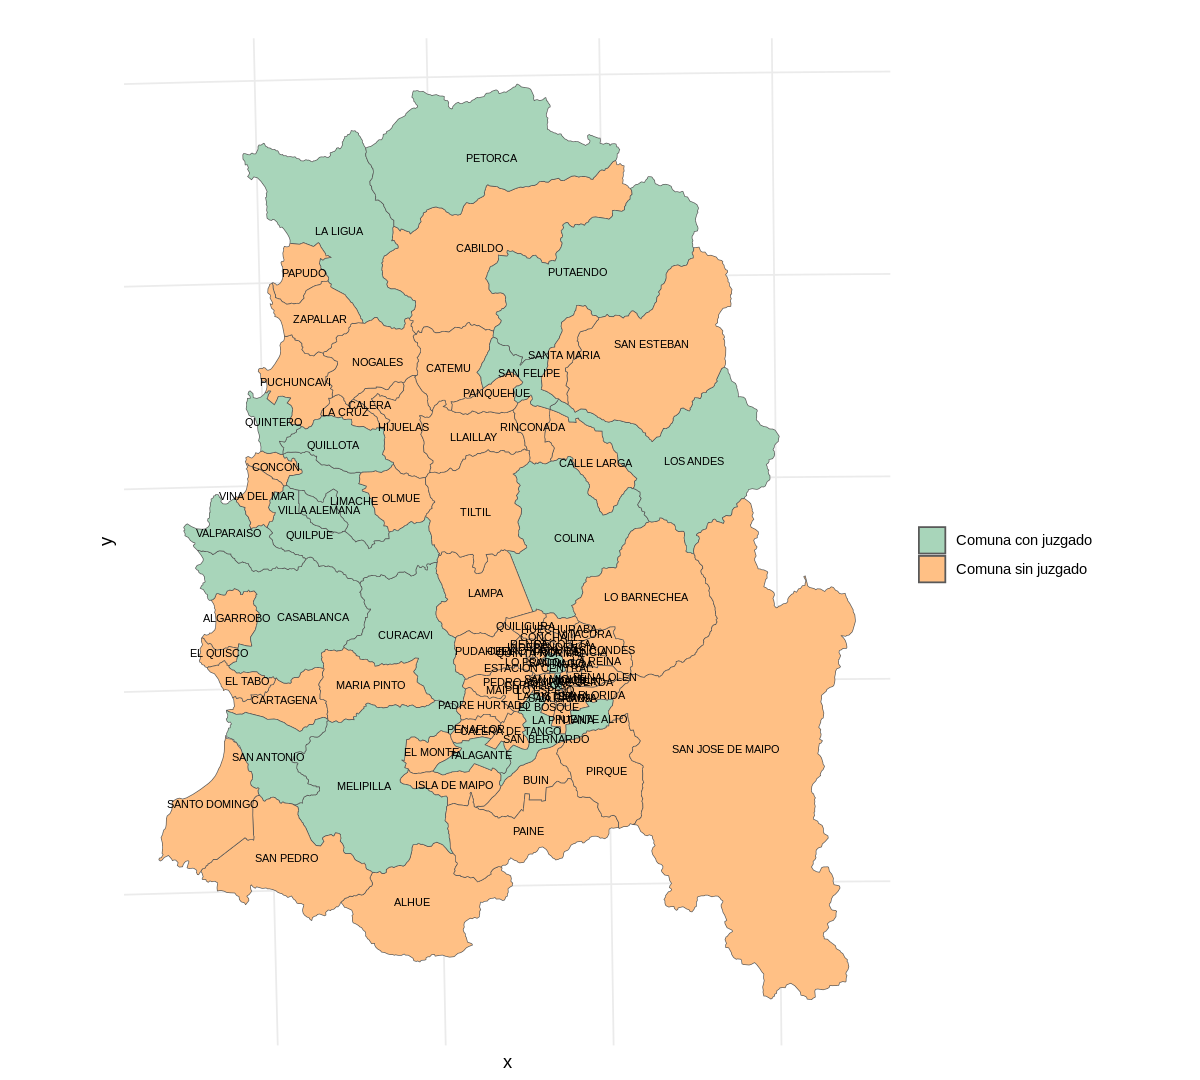

In [ ]:
# 02 - ZONA CENTRO-METROPOLITANA
bb <- st_bbox(c(xmin = -72, xmax = -69, ymin = -35, ymax = -31), crs = st_crs(mapa_sf))

mapa_sf4 <- mapa_sf %>%
  filter(codigo_region %in% c("05","13"))

mapa_sf4_cropped <- st_crop(mapa_sf4, bb)

# Proyectar
mapa_sf4_proj <- st_transform(mapa_sf4_cropped, crs = 5361)

mapa_sf4_proj$color_comuna <- ifelse(mapa_sf4_proj$nombre_comuna %in% c(
            "CASABLANCA", "COLINA", "CURACAVI", "ISLA PASCUA", "LA CALERA", "LA LIGUA", "LIMACHE", "LOS ANDES", "MELIPILLA",
            "PETORCA","PUENTE ALTO", "PUTAENDO", "QUILLOTA", "QUILPUE", "QUINTERO", "SAN ANTONIO", "SAN BERNARDO", "SAN FELIPE",
            "SAN MIGUEL","SANTIAGO", "TALAGANTE", "VALPARAISO", "VILLA ALEMANA", "VIÑA DEL MAR"
            ),
"Comuna con juzgado" , "Comuna sin juzgado" )

ggplot(data = mapa_sf4_proj) +
  geom_sf(aes(fill = color_comuna)) +
  geom_sf_text(aes(label = nombre_comuna), nudge_y = 0, nudge_x = 0, size = 2.3) +
  theme_minimal() +
  labs(title = "") +
  theme(
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()
  ) +
  scale_fill_manual(name="",values = c("Comuna con juzgado" = "#A8D5BA", "Comuna sin juzgado" = "#FFC085"))


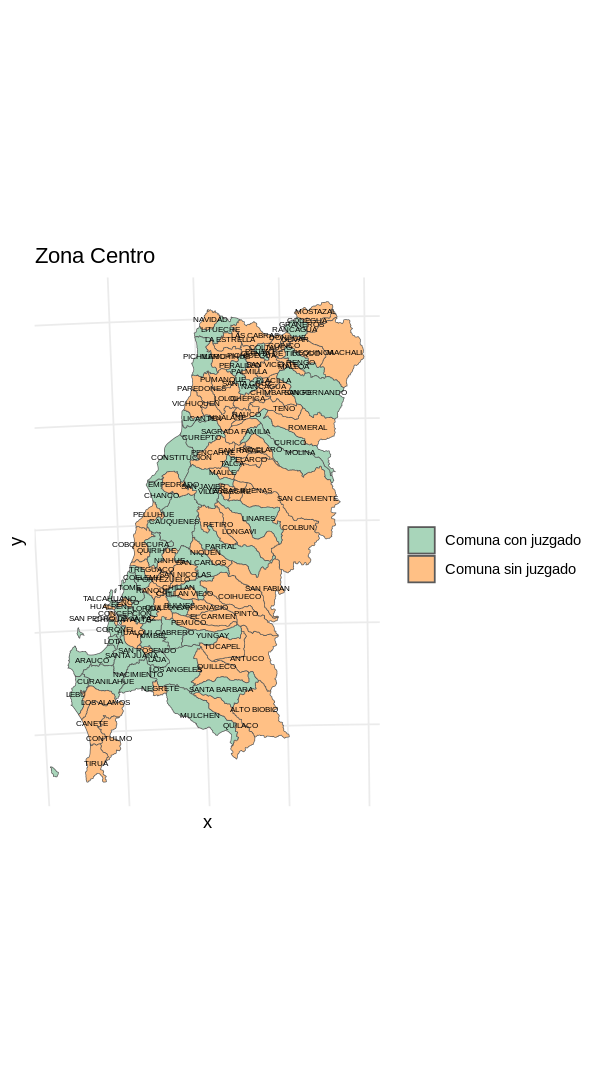

In [ ]:
# ZONA 3: VI, VII, XVI, VIII (CENTRO SUR): 47 comunas
#   DEL LIBERTADOR B. O'HIGGINS(10), DEL MAULE(11), DE ÑUBLE(6), DEL BIOBIO(20)
mapa_sf4 <- mapa_sf %>%
  filter(codigo_region %in% c("06", "07", "16", "08"))

# Proyectar
mapa_sf4_proj <- st_transform(mapa_sf4, crs = 5361)

mapa_sf4_proj$color_comuna <- ifelse(mapa_sf4_proj$nombre_comuna %in% c(
            "ARAUCO", "BULNES", "CABRERO", "CAÑETE", "CAUQUENES", "CHANCO", "CHIGUAYANTE", "CHILLAN", "COELEMU",
            "CONCEPCION", "CONSTITUCION", "CORONEL", "CURANILAHUE", "CUREPTO", "CURICO", "FLORIDA", "GRANEROS",
            "LAJA", "LEBU", "LICANTEN", "LINARES", "LITUECHE", "LOS ANGELES", "LOTA", "MOLINA", "MULCHEN", "NACIMIENTO",
            "PARRAL", "PERALILLO", "PEUMO", "PICHILEMU", "QUIRIHUE", "RANCAGUA", "RENGO", "SAN CARLOS", "SAN FERNANDO",
            "SAN JAVIER", "SAN PEDRO LA PAZ", "SAN VICENTE TAGUA-TAGUA", "SANTA BARBARA", "SANTA CRUZ","SANTA JUANA",
            "TALCA", "TALCAHUANO", "TOME", "YUMBEL", "YUNGAY"
            ),
"Comuna con juzgado" , "Comuna sin juzgado" )

ggplot(data = mapa_sf4_proj) +
  geom_sf(aes(fill = color_comuna)) +
  geom_sf_text(aes(label = nombre_comuna), nudge_y = 0, nudge_x = 0, size = 1.7) +
  theme_minimal() +
  labs(title = "Zona Centro Sur") +
  theme(
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()
  ) +
  scale_fill_manual(name="",values = c("Comuna con juzgado" = "#A8D5BA", "Comuna sin juzgado" = "#FFC085"))

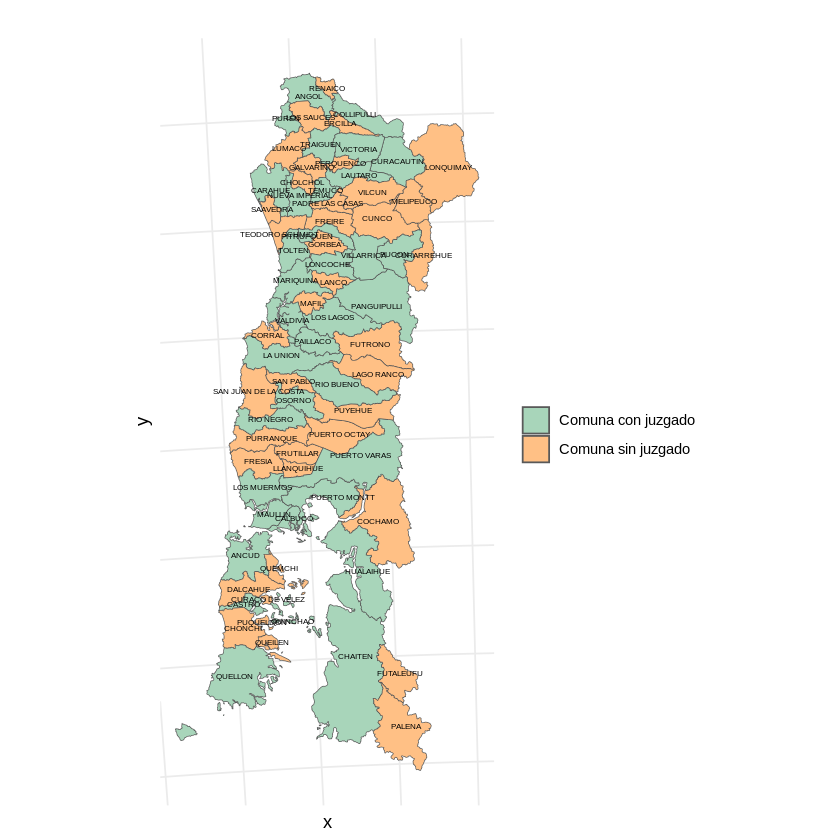

In [ ]:
# ZONA 4: IX, XIV, X (SUR): 35 comunas
#   DE LA ARAUCANIA(15), DE LOS RIOS(7), DE LOS LAGOS(13)
mapa_sf4 <- mapa_sf %>%
  filter(codigo_region %in% c("09", "14", "10"))

# Proyectar
mapa_sf4_proj <- st_transform(mapa_sf4, crs = 5361)

mapa_sf4_proj$color_comuna <- ifelse(mapa_sf4_proj$nombre_comuna %in% c(
            "ANCUD", "ANGOL", "CALBUCO", "CARAHUE", "CASTRO", "CHAITEN", "COLLIPULLI", "CURACAUTIN", "HUALAIHUE", "LA UNION", "LAUTARO",
            "LONCOCHE", "LOS LAGOS", "LOS MUERMOS", "MARIQUINA", "MAULLIN", "NUEVA IMPERIAL", "OSORNO", "PAILLACO", "PANGUIPULLI",
            "PITRUFQUEN", "PUCON", "PUERTO MONTT", "PUERTO VARAS", "PUREN", "QUELLON", "QUINCHAO", "RIO BUENO", "RIO NEGRO",
            "TEMUCO", "TOLTEN", "TRAIGUEN", "VALDIVIA", "VICTORIA", "VILLARRICA"
            ),
"Comuna con juzgado" , "Comuna sin juzgado" )

ggplot(data = mapa_sf4_proj) +
  geom_sf(aes(fill = color_comuna)) +
  geom_sf_text(aes(label = nombre_comuna), nudge_y = 0, nudge_x = 0, size = 1.7) +
  theme_minimal() +
  labs(title = " ") +
  theme(
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()
  ) +
  scale_fill_manual(name="",values = c("Comuna con juzgado" = "#A8D5BA", "Comuna sin juzgado" = "#FFC085"))

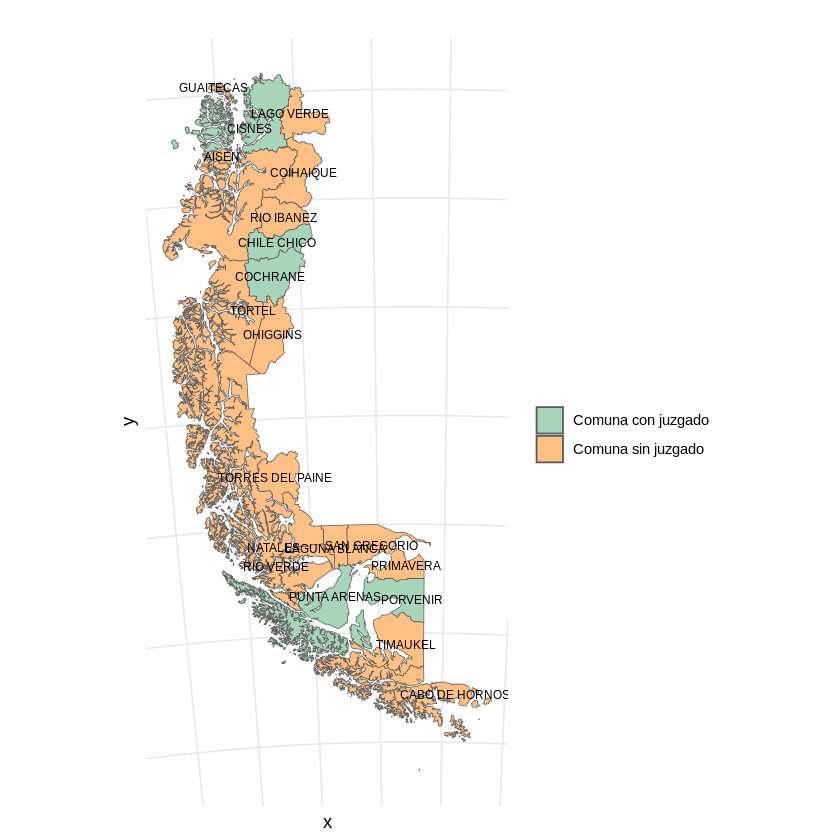

In [ ]:
# ZONA 5 (AUSTRAL): XI y XII: 9
#   DE AISEN DEL GRAL. C. IBAÑEZ DEL CAMPO(5), DE MAGALLANES Y DE LA ANTARTICA CHILENA(4)
mapa_sf4 <- mapa_sf %>%
  filter(codigo_region %in% c("11", "12"))

# Proyectar
mapa_sf4_proj <- st_transform(mapa_sf4, crs = 5361)

mapa_sf4_proj$color_comuna <- ifelse(mapa_sf4_proj$nombre_comuna %in% c(
            "CABO HORNOS","CHILE CHICO","CISNES","COCHRANE","COYHAIQUE",
            "PORVENIR", "PUERTO AYSEN", "PUERTO NATALES","PUNTA ARENAS"
            ),
"Comuna con juzgado" , "Comuna sin juzgado" )

ggplot(data = mapa_sf4_proj) +
  geom_sf(aes(fill = color_comuna)) +
  geom_sf_text(aes(label = nombre_comuna), nudge_y = 0, nudge_x = 0, size = 2.5) +
  theme_minimal() +
  labs(title = " ") +
  theme(
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()
  ) +
  scale_fill_manual(name="",values = c("Comuna con juzgado" = "#A8D5BA", "Comuna sin juzgado" = "#FFC085"))